In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)

In [3]:
gdf_gdl.shape

(8499, 4)

## Espacios Públicos QRO

In [4]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)

In [5]:
gdf_qro.shape

(4814, 9)

## Espacios Públicos CDMX

In [6]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)

In [7]:
gdf_cdmx.shape

(11609, 13)

## Juntamos en un dataset

In [8]:
gdf_gdl = gdf_gdl.set_crs("EPSG:4326", allow_override=True)
gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)
print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_qro: EPSG:4326
CRS of gdf_cdmx: EPSG:4326


In [9]:
geodataframes = [gdf_gdl, gdf_qro, gdf_cdmx]
gdf = pd.concat(geodataframes)
gdf = gdf['geometry']
gdf.head()

0    POLYGON ((672507.02800 2272132.20130, 672520.1...
1    POLYGON ((672520.12560 2272170.35300, 672507.0...
2    POLYGON ((672494.32530 2272095.20510, 672480.3...
3    POLYGON ((672480.36630 2272060.73140, 672494.3...
4    POLYGON ((672468.71720 2272020.61270, 672456.8...
Name: geometry, dtype: geometry

In [10]:
gdf.shape

(24922,)

## Hexágonos 3 ciudades

In [11]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
hex_table_tempt = "temperature_analysis_hex"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
JOIN {hex_schema}.{hex_table_tempt} h2
ON h1.hex_id = h2.hex_id
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b4995b804ecfff,"POLYGON ((-99.13393 19.45982, -99.13375 19.460...",CDMX
1,8b4995b84845fff,"POLYGON ((-99.15293 19.42654, -99.15275 19.426...",CDMX
2,8b4995b80571fff,"POLYGON ((-99.13590 19.45491, -99.13573 19.455...",CDMX
3,8b4995b80562fff,"POLYGON ((-99.13637 19.45472, -99.13620 19.454...",CDMX
4,8b4995ba06cbfff,"POLYGON ((-99.16759 19.41276, -99.16741 19.412...",CDMX


In [12]:
hex_gdl.shape

(807653, 3)

In [13]:
hex_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [14]:
contador_gdll = np.sum(hex_gdl['city'] == 'Guadalajara')
contador_cdmxx = np.sum(hex_gdl['city'] == 'CDMX')
#contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdll} \nNúmero de hexágonos Cdmx: {contador_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


In [15]:
hex_gdl = hex_gdl.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


In [16]:
gdl_samples = 200000
cdmx_samples = 150000
#qro_samples = 50000

# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = hex_gdl[hex_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = hex_gdl[hex_gdl['city'] == 'CDMX'].sample(n=cdmx_samples, random_state=42)

# Randomly sample 50,000 hexagons of Queretaro
#sample_with_Queretaro = hex_gdl[hex_gdl['city'] == 'Queretaro'].sample(n=qro_samples, random_state=42)

# Concatenate the two samples to get the final subsample
hex_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx]) #sample_with_Queretaro])
hex_gdf.reset_index(drop = True, inplace = True)
hex_gdf.head()

,hex_id,geometry,city
0,8b498c92e989fff,"POLYGON ((-103.21317 20.56265, -103.21299 20.5...",Guadalajara
1,8b49aa2dd2ebfff,"POLYGON ((-103.32879 20.57985, -103.32862 20.5...",Guadalajara
2,8b49ab59598efff,"POLYGON ((-103.43018 20.60413, -103.43000 20.6...",Guadalajara
3,8b498c968ad8fff,"POLYGON ((-103.38631 20.68514, -103.38613 20.6...",Guadalajara
4,8b498c950a5efff,"POLYGON ((-103.25456 20.69632, -103.25439 20.6...",Guadalajara


In [17]:
contador_gdl = np.sum(hex_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdf['city'] == 'CDMX')
#contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 200000 
Número de hexágonos Cdmx: 150000


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [18]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b4995b804ecfff,"POLYGON ((-99.13393 19.45982, -99.13375 19.460...",CDMX,0
1,8b4995b84845fff,"POLYGON ((-99.15293 19.42654, -99.15275 19.426...",CDMX,0
2,8b4995b80571fff,"POLYGON ((-99.13590 19.45491, -99.13573 19.455...",CDMX,0
3,8b4995b80562fff,"POLYGON ((-99.13637 19.45472, -99.13620 19.454...",CDMX,0
4,8b4995ba06cbfff,"POLYGON ((-99.16759 19.41276, -99.16741 19.412...",CDMX,0


In [19]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 708008 
Número de Hexágonos con Espacios Públicos: 99645
Número total de Hexágonos: 807653


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [20]:
import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'temperature_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()

hex_id
geometry
res
temperature_mean
temperature_std
temperature_median
temperature_max
temperature_min
temperature_diff
temperature_tend
city
temp_diff_mean


In [21]:
import psycopg2

#Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

#Ejecutar la consulta para obtener los nombres de las columnas
cur.execute("""
    SELECT column_name 
    FROM information_schema.columns 
    WHERE table_schema = 'raster_analysis' 
    AND table_name = 'ndvi_analysis_hex';
""")

#Obtener los resultados
columns = cur.fetchall()

#Imprimir los nombres de las columnas
for column in columns:
    print(column[0])

cur.close()
conn.close()

hex_id
geometry
res
ndvi_mean
ndvi_std
ndvi_median
ndvi_max
ndvi_min
ndvi_diff
ndvi_tend
city


In [22]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_tempt = "temperature_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
temp = "temp"
poblation = "POBTOT"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Queretaro'
n = '11'

query = f'''
SELECT 
    temp.hex_id, 
    temp.city, 
    temp.geometry AS geometry,  
    temp.res AS temp_res,
    ndmi.geometry AS ndmi_geometry, 
    ndmi.city AS ndmi_city, 
    ndmi.res AS ndmi_res, 
    ndvi.geometry AS ndvi_geometry, 
    ndvi.city AS ndvi_city, 
    ndvi.res AS ndvi_res, 
    ndvi.ndvi_mean, 
    ndvi.ndvi_std, 
    ndvi.ndvi_median, 
    ndvi.ndvi_max, 
    ndvi.ndvi_min, 
    ndvi.ndvi_diff, 
    ndvi.ndvi_tend,
    ndmi.ndmi_mean, 
    ndmi.ndmi_median, 
    ndmi.ndmi_diff, 
    temp.temp_diff_mean
FROM 
    {hex_schema}.{hex_table_tempt} temp  
INNER JOIN 
    {hex_schema}.{hex_table} ndmi 
    ON temp.hex_id = ndmi.hex_id
INNER JOIN 
    {hex_schema}.{hex_tablee} ndvi 
    ON ndmi.hex_id = ndvi.hex_id
WHERE 
    temp.city IN ('{c1}', '{c2}') 
    AND temp.res = {n}
'''

intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b499584a383fff,CDMX,"POLYGON ((-99.18000 19.35860, -99.17982 19.358...",11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,...,0.093463,0.393257,0.402223,0.294147,0.108076,-0.003056,0.047486,0.047518,0.023174,-0.999885
1,8b4995b8ec2afff,CDMX,"POLYGON ((-99.15481 19.48660, -99.15464 19.486...",11,0103000020E61000000100000007000000015DB775E8C9...,CDMX,11,0103000020E61000000100000007000000015DB775E8C9...,CDMX,11,...,0.011216,0.041535,0.056212,0.027292,0.028920,-0.000275,-0.044624,-0.047098,0.041608,2.292706
2,8b4995b13ccbfff,CDMX,"POLYGON ((-99.22927 19.41584, -99.22909 19.416...",11,0103000020E6100000010000000700000054E1325EACCE...,CDMX,11,0103000020E6100000010000000700000054E1325EACCE...,CDMX,11,...,0.080896,0.381725,0.384054,0.312453,0.071600,-0.002789,0.074351,0.076777,0.017964,-1.819908
3,8b4995b102e2fff,CDMX,"POLYGON ((-99.24227 19.40455, -99.24210 19.404...",11,0103000020E610000001000000070000008629C56881CF...,CDMX,11,0103000020E610000001000000070000008629C56881CF...,CDMX,11,...,0.057511,0.287090,0.293939,0.233838,0.060102,-0.001896,0.011942,0.009077,0.030499,-0.653675
4,8b4995b13963fff,CDMX,"POLYGON ((-99.24224 19.40820, -99.24206 19.408...",11,0103000020E6100000010000000700000054E4D8E280CF...,CDMX,11,0103000020E6100000010000000700000054E4D8E280CF...,CDMX,11,...,0.054689,0.251578,0.304285,0.211149,0.093136,-0.000826,0.045733,0.045949,0.050148,-2.558189
5,8b4995b10093fff,CDMX,"POLYGON ((-99.23265 19.39673, -99.23247 19.396...",11,0103000020E61000000100000007000000C18B8EBFE3CE...,CDMX,11,0103000020E61000000100000007000000C18B8EBFE3CE...,CDMX,11,...,0.092652,0.439031,0.436319,0.335375,0.100944,-0.003267,0.113424,0.114254,0.044230,-4.933251
6,8b4995b10c1dfff,CDMX,"POLYGON ((-99.23197 19.38839, -99.23179 19.388...",11,0103000020E6100000010000000700000006EE9085D8CE...,CDMX,11,0103000020E6100000010000000700000006EE9085D8CE...,CDMX,11,...,0.130354,0.439810,0.496826,0.302083,0.194743,-0.004584,0.051198,0.049352,0.085850,-1.820404
7,8b4995b10d64fff,CDMX,"POLYGON ((-99.23603 19.38444, -99.23585 19.384...",11,0103000020E61000000100000007000000851539161BCF...,CDMX,11,0103000020E61000000100000007000000851539161BCF...,CDMX,11,...,0.032036,0.088760,0.112240,0.062855,0.049385,-0.001151,-0.022371,-0.024008,0.041082,0.558564
8,8b4995b10998fff,CDMX,"POLYGON ((-99.23806 19.38586, -99.23788 19.386...",11,0103000020E6100000010000000700000096CC275B3CCF...,CDMX,11,0103000020E6100000010000000700000096CC275B3CCF...,CDMX,11,...,0.073500,0.257912,0.293653,0.198211,0.095442,-0.002854,-0.002102,-0.006449,0.067018,-0.189121
9,8b4995b33635fff,CDMX,"POLYGON ((-99.25893 19.36859, -99.25876 19.368...",11,0103000020E610000001000000070000006E60515A92D0...,CDMX,11,0103000020E610000001000000070000006E60515A92D0...,CDMX,11,...,0.052281,0.148302,0.201024,0.105154,0.095869,-0.001475,-0.001687,0.000657,0.063929,0.329181


In [23]:
intt_gdl.shape

(807653, 21)

In [24]:
intt_gdl['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [25]:
intt_gdll = np.sum(intt_gdl['city'] == 'Guadalajara')
intt_cdmxx = np.sum(intt_gdl['city'] == 'CDMX')
#intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {intt_gdll} \nNúmero de hexágonos Cdmx: {intt_cdmxx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


## Intersección

In [26]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [27]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')

In [28]:
inter.drop(columns=['index_right','city_right','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995b804ecfff,"POLYGON ((-99.13393 19.45982, -99.13375 19.460...",CDMX,0,11,0103000020E610000001000000070000001787315A93C8...,CDMX,11,0103000020E610000001000000070000001787315A93C8...,CDMX,...,0.024206,0.103129,0.114128,0.073817,0.040311,-0.000877,-0.031195,-0.034813,0.037802,2.800092
138491,8b4995b80453fff,"POLYGON ((-99.13440 19.45962, -99.13422 19.459...",CDMX,0,11,0103000020E610000001000000070000001787315A93C8...,CDMX,11,0103000020E610000001000000070000001787315A93C8...,CDMX,...,0.024206,0.103129,0.114128,0.073817,0.040311,-0.000877,-0.031195,-0.034813,0.037802,2.800092
227683,8b4995b80456fff,"POLYGON ((-99.13406 19.45886, -99.13388 19.459...",CDMX,0,11,0103000020E610000001000000070000001787315A93C8...,CDMX,11,0103000020E610000001000000070000001787315A93C8...,CDMX,...,0.024206,0.103129,0.114128,0.073817,0.040311,-0.000877,-0.031195,-0.034813,0.037802,2.800092
294678,8b4995b80450fff,"POLYGON ((-99.13446 19.45914, -99.13429 19.459...",CDMX,0,11,0103000020E610000001000000070000001787315A93C8...,CDMX,11,0103000020E610000001000000070000001787315A93C8...,CDMX,...,0.024206,0.103129,0.114128,0.073817,0.040311,-0.000877,-0.031195,-0.034813,0.037802,2.800092
314968,8b4995b804e1fff,"POLYGON ((-99.13352 19.45953, -99.13335 19.459...",CDMX,0,11,0103000020E610000001000000070000001787315A93C8...,CDMX,11,0103000020E610000001000000070000001787315A93C8...,CDMX,...,0.024206,0.103129,0.114128,0.073817,0.040311,-0.000877,-0.031195,-0.034813,0.037802,2.800092


In [29]:
#pd.isna(inter).sum()

In [30]:
inter['temp_diff_mean'] = inter['temp_diff_mean'].fillna(0)

In [31]:
#pd.isna(inter).sum()

In [32]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
#contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 4144415 
Número de hexágonos Cdmx: 2519284


In [33]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 5967752 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 6663699


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [34]:
num_samples = len(inter[inter['EspPublico'] == 1])

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995848826fff,"POLYGON ((-99.20497 19.33374, -99.20479 19.333...",CDMX,1,11,0103000020E61000000100000007000000E0B007321FCD...,CDMX,11,0103000020E61000000100000007000000E0B007321FCD...,CDMX,...,0.131584,0.587075,0.640236,0.464376,0.175860,-0.004680,0.118150,0.113173,0.064039,-2.454085
1,8b4995b8e474fff,"POLYGON ((-99.15193 19.49505, -99.15175 19.495...",CDMX,1,11,0103000020E61000000100000007000000F3B3CE40BAC9...,CDMX,11,0103000020E61000000100000007000000F3B3CE40BAC9...,CDMX,...,0.026850,0.098481,0.124901,0.075488,0.049413,-0.000931,-0.039512,-0.044277,0.035820,6.429949
2,8b49958f0b03fff,"POLYGON ((-98.97648 19.30304, -98.97630 19.303...",CDMX,1,11,0103000020E61000000100000007000000D92B1B5686BE...,CDMX,11,0103000020E61000000100000007000000D92B1B5686BE...,CDMX,...,0.151385,0.261043,0.552578,0.158823,0.393755,-0.002555,-0.045970,-0.085946,0.311650,4.900867
3,8b499585e860fff,"POLYGON ((-99.12255 19.32701, -99.12237 19.327...",CDMX,1,11,0103000020E61000000100000007000000416A9D33D1C7...,CDMX,11,0103000020E61000000100000007000000416A9D33D1C7...,CDMX,...,0.039913,0.179176,0.195820,0.146073,0.049747,-0.001234,-0.008248,-0.009907,0.048899,-0.363037
4,8b499584b759fff,"POLYGON ((-99.19648 19.37493, -99.19630 19.375...",CDMX,1,11,0103000020E61000000100000007000000BA21EF1F92CC...,CDMX,11,0103000020E61000000100000007000000BA21EF1F92CC...,CDMX,...,0.081157,0.329026,0.366904,0.261683,0.105221,-0.003058,0.011501,0.015553,0.045284,0.228703


In [35]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 695947 
Número de Hexágonos con Espacios Públicos: 695947
Número total de Hexágonos: 1391894


In [36]:
inter.shape

(1391894, 22)

## Métodos de Clasificación

In [37]:
x = inter[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', 'temp_diff_mean']]
y = inter['EspPublico']

In [38]:
y.unique()

array([1, 0])

### Regresión Logística

In [39]:
# Suponiendo que x y y ya están definidos
'''x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo

# Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

# Ahora separa de nuevo x_train y y_train
x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

# Hacer lo mismo para el conjunto de prueba
test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

# Asegurarte de que el conjunto de prueba no tenga NaN
x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

# Escalar los datos
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)'''

"x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)\n\n# Reemplazar valores infinitos por NaN\nx_train.replace([np.inf, -np.inf], np.nan, inplace=True)\nx_test.replace([np.inf, -np.inf], np.nan, inplace=True)\n\n# Combinar x y y para eliminar filas con NaN de forma coherente\ntrain_data = x_train.copy()\ntrain_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo\n\n# Eliminar filas con NaN en el conjunto de entrenamiento\ntrain_data.dropna(inplace=True)\n\n# Ahora separa de nuevo x_train y y_train\nx_train_clean = train_data.drop(columns=['target'])\ny_train_clean = train_data['target']\n\n# Hacer lo mismo para el conjunto de prueba\ntest_data = x_test.copy()\ntest_data['target'] = y_test\ntest_data.dropna(inplace=True)\n\n# Asegurarte de que el conjunto de prueba no tenga NaN\nx_test_clean = test_data.drop(columns=['target'])\ny_test_clean = test_data['target']\n\n# Escalar los datos\nscaler = StandardScaler(

In [40]:
'''clf = LogisticRegression()
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()'''

'clf = LogisticRegression()\nclf.fit(x_train_scale, y_train_clean)\n\ny_pred = clf.predict(x_test_scale)\n\n#Generar matriz de confusión:\ncm = confusion_matrix(y_test_clean, y_pred)\nclass_labels = [\'Espacio Público\', \'No Espacio Público\']\n\nplt.figure(figsize=(10, 7))\nsns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize=12, fontweight=\'bold\')\nplt.ylabel(\'Actual\', fontsize=12, fontweight=\'bold\')\nplt.title(\'Matriz de Confusión\', fontsize=15, fontweight=\'bold\')\nplt.show()'

In [41]:
#accuracy = accuracy_score(y_test_clean, y_pred)
#print(f'Accuracy: {accuracy}')

In [42]:
#print(classification_report(y_test_clean, y_pred))

### Naive Bayes

In [43]:
#nb = GaussianNB()
#nb.fit(x_train_scale, y_train_clean)

In [44]:
'''y_prend = nb.predict(x_test_clean)
cm = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'y_prend = nb.predict(x_test_clean)\ncm = confusion_matrix(y_test_clean, y_prend)\nclass_labels = [\'Espacio Público\', \'No Espacio Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [45]:
#accuracy = accuracy_score(y_test_clean, y_prend)
#print(f'Accuracy: {accuracy}')

In [46]:
#print(classification_report(y_test_clean, y_prend))

## Random Forest Classifier (RFC)

In [47]:
'''rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test_clean)'''

'rf = RandomForestClassifier(n_estimators=120, random_state=42)  \nrf.fit(x_train_scale, y_train_clean)\n\n# Realizar predicciones en el conjunto de prueba\ny_predd = rf.predict(x_test_clean)'

In [48]:
'''cm = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm = confusion_matrix(y_test_clean, y_predd)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [49]:
#accuracy = accuracy_score(y_test_clean, y_predd)
#print(f'Accuracy: {accuracy}')

In [50]:
#print(classification_report(y_test_clean, y_predd))

## Ada Boost Classifier

In [51]:
#model = AdaBoostClassifier(n_estimators = 1)
#model.fit(x_train_scale, y_train_clean)

In [52]:
#predictions = model.predict(x_test_clean)
#predictions

In [53]:
'''cm = confusion_matrix(y_test_clean, predictions)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm = confusion_matrix(y_test_clean, predictions)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [54]:
#print(classification_report(y_test_clean, predictions))

In [55]:
#accuracy = accuracy_score(y_test_clean, predictions)
#print(f'Accuracy: {accuracy}')

## XGBClassifier

In [56]:
#model2 = xgb.XGBClassifier()
#model2.fit(x_train_scale, y_train_clean)

In [57]:
#predictions2 = model2.predict(x_test_clean)
#predictions2

In [58]:
'''cm = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm = confusion_matrix(y_test_clean, predictions2)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [59]:
#print(classification_report(y_test_clean, predictions2))

In [60]:
#accuracy = accuracy_score(y_test_clean, predictions2)
#print(f'Accuracy: {accuracy}')

## Decision Tree Classification

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
#model3 = DecisionTreeClassifier()
#model3.fit(x_train_scale, y_train_clean)

In [63]:
#predictions3 = model3.predict(x_test_clean)
#predictions3

In [64]:
'''cm = confusion_matrix(y_test_clean, predictions3)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm = confusion_matrix(y_test_clean, predictions3)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [65]:
#print(classification_report(y_test_clean, predictions3))

In [66]:
#accuracy = accuracy_score(y_test_clean, predictions3)
#print(f'Accuracy: {accuracy}')

## Clasificador con población.

In [67]:
'''import psycopg2

# Conectar a la base de datos
conn = psycopg2.connect(
    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database = "postgres",
    user= "odc_writer",
    password = "writejacobs1918"
)

cur = conn.cursor()

# Ejecutar la consulta para obtener el esquema de la tabla
table_name = 'hex_censo_mza_2020_res9'
cur.execute(f"""
    SELECT table_schema
    FROM information_schema.tables
    WHERE table_name = '{table_name}';
""")

# Obtener los resultados
schema = cur.fetchone()
print(f"El esquema de la tabla {table_name} es: {schema[0]}")

cur.close()
conn.close()'''

'import psycopg2\n\n# Conectar a la base de datos\nconn = psycopg2.connect(\n    host = "hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database = "postgres",\n    user= "odc_writer",\n    password = "writejacobs1918"\n)\n\ncur = conn.cursor()\n\n# Ejecutar la consulta para obtener el esquema de la tabla\ntable_name = \'hex_censo_mza_2020_res9\'\ncur.execute(f"""\n    SELECT table_schema\n    FROM information_schema.tables\n    WHERE table_name = \'{table_name}\';\n""")\n\n# Obtener los resultados\nschema = cur.fetchone()\nprint(f"El esquema de la tabla {table_name} es: {schema[0]}")\n\ncur.close()\nconn.close()'

In [68]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
n = "9"
t = "urban"

#Consulta para la tabla de población (solo tipo urbano y ciudades seleccionadas):
query_pob = f"""
SELECT * 
FROM {hex_schema_pob}.{hex_table_pob} 
WHERE city IN ('{c1}', '{c2}') 
AND type = '{t}'
"""

hex_gdl_pob = aup.gdf_from_query(query_pob, geometry_col='geometry')
hex_gdl_pob.head(5)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.33230 20.6...",14039,Guadalajara,Guadalajara,urban
4,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban


In [69]:
'''import psycopg2

conn = psycopg2.connect(
    host="hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",
    database="postgres",
    user="odc_writer",
    password="writejacobs1918"
)

cur = conn.cursor()

table_name = 'hex_censo_mza_2020_res9'

cur.execute(f"""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = '{table_name}';
""")

columns = cur.fetchall()
for column in columns:
    print(column[0])

# Cerrar cursor y conexión
cur.close()
conn.close()'''



'import psycopg2\n\nconn = psycopg2.connect(\n    host="hippocampus.cswst4rid7eb.us-east-2.rds.amazonaws.com",\n    database="postgres",\n    user="odc_writer",\n    password="writejacobs1918"\n)\n\ncur = conn.cursor()\n\ntable_name = \'hex_censo_mza_2020_res9\'\n\ncur.execute(f"""\n    SELECT column_name\n    FROM information_schema.columns\n    WHERE table_name = \'{table_name}\';\n""")\n\ncolumns = cur.fetchall()\nfor column in columns:\n    print(column[0])\n\n# Cerrar cursor y conexión\ncur.close()\nconn.close()'

In [70]:
#Consulta para la tabla de manzanas (solo ciudades seleccionadas):
query_mza = f"""
SELECT hex_id_9, pobtot, geometry
FROM {hex_schema_mza}.{hex_table_mza} 
"""

hex_gdl_mza = aup.gdf_from_query(query_mza, geometry_col='geometry')

In [71]:
pob = hex_gdl_pob.shape
mza = hex_gdl_mza.shape

print(pob)
print(mza)

(13629, 6)
(119059, 3)


In [72]:
hex_gdl_pob['city'].unique()

array(['Guadalajara', 'CDMX'], dtype=object)

In [73]:
hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
t = "urban"


query_join = f"""
SELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry
FROM {hex_schema_pob}.{hex_table_pob} pob
INNER JOIN {hex_schema_mza}.{hex_table_mza} mza
ON pob.hex_id_9 = mza.hex_id_9
WHERE pob.city IN ('{c1}', '{c2}') 
AND pob.type = '{t}'
"""

hex_gdl_join = aup.gdf_from_query(query_join, geometry_col='geometry')

hex_gdl_join.head(5)


,hex_id_9,city,type,pobtot,geometry
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387..."
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349..."
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284..."
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376..."
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330..."


In [74]:
contador_gdl_join = np.sum(hex_gdl_join['city'] == 'Guadalajara')
contador_cdmxx_join = np.sum(hex_gdl_join['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl_join} \nNúmero de hexágonos Cdmx: {contador_cdmxx_join}')

Número de hexágonos Gdl: 5650 
Número de hexágonos Cdmx: 6165


In [75]:
hex_gdl_join = hex_gdl_join.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [76]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl_join['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl_join.head()

,hex_id_9,city,type,pobtot,geometry,EspPublico
0,894995b1507ffff,CDMX,urban,1159.0,"POLYGON ((-99.26246 19.38575, -99.26122 19.387...",1
1,894995b2277ffff,CDMX,urban,736.0,"POLYGON ((-99.30773 19.34790, -99.30650 19.349...",0
2,89499584547ffff,CDMX,urban,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284...",1
3,8949958cc9bffff,CDMX,urban,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376...",1
4,89499585e13ffff,CDMX,urban,3163.0,"POLYGON ((-99.11471 19.32935, -99.11347 19.330...",1


In [77]:
contador_ceros_join = np.sum(hex_gdl_join['EspPublico'] == 0)
contador_uno_join = np.sum(hex_gdl_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 7364 
Número de Hexágonos con Espacios Públicos: 4451
Número total de Hexágonos: 11815


## Intersección espacial

In [78]:
pd.isna(hex_gdl_join).sum()

hex_id_9      0
city          0
type          0
pobtot        0
geometry      0
EspPublico    0
dtype: int64

In [79]:
hex_gdl_pob = hex_gdl_pob.set_crs("EPSG:4326")
hex_gdl_mza = hex_gdl_mza.set_crs("EPSG:4326")

In [80]:
inter_join = gpd.sjoin(hex_gdl_pob, hex_gdl_mza, op='intersects')
print(inter_join)

         hex_id_9_left                                           geometry  \
0      89498c96e0bffff  POLYGON ((-103.35267 20.66765, -103.35145 20.6...   
82     89498c96ecfffff  POLYGON ((-103.35003 20.66229, -103.34881 20.6...   
333    89498c96e47ffff  POLYGON ((-103.34935 20.66910, -103.34813 20.6...   
389    89498c96e1bffff  POLYGON ((-103.35301 20.66425, -103.35179 20.6...   
721    89498c96e57ffff  POLYGON ((-103.34969 20.66569, -103.34847 20.6...   
...                ...                                                ...   
13594  894995b96d3ffff  POLYGON ((-99.05118 19.43500, -99.04994 19.436...   
13534  894995b96cfffff  POLYGON ((-99.05030 19.44172, -99.04906 19.443...   
13550  894995b9657ffff  POLYGON ((-99.04985 19.44507, -99.04861 19.446...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   
13570  894995b96cbffff  POLYGON ((-99.04746 19.43971, -99.04622 19.441...   

      CVEGEO               NOMGEO         city   type  index_right  \
0    

In [81]:
inter_join.drop(columns=['index_right', 'hex_id_9_right'], inplace=True)
inter_join.rename(columns={"hex_id_9_left": "hex_id_9"}, inplace=True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0


In [82]:
pd.isna(inter_join).sum()

hex_id_9    0
geometry    0
CVEGEO      0
NOMGEO      0
city        0
type        0
pobtot      0
dtype: int64

In [83]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = inter_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

inter_join['EspPublico'] = intersects_public_spaces.astype(int)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
82,89498c96ecfffff,"POLYGON ((-103.35003 20.66229, -103.34881 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
333,89498c96e47ffff,"POLYGON ((-103.34935 20.66910, -103.34813 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
389,89498c96e1bffff,"POLYGON ((-103.35301 20.66425, -103.35179 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0
721,89498c96e57ffff,"POLYGON ((-103.34969 20.66569, -103.34847 20.6...",14039,Guadalajara,Guadalajara,urban,975.0,0


In [84]:
cont_ceros_join = np.sum(inter_join['EspPublico'] == 0)
cont_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 49764 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 80632


## Submuestreo población

In [85]:
num_samples_join = len(inter_join[inter_join['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = inter_join[inter_join['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = inter_join[inter_join['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
inter_join = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
inter_join.reset_index(drop = True, inplace = True)
inter_join.head()

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,pobtot,EspPublico
0,8949958518bffff,"POLYGON ((-99.11824 19.30248, -99.11700 19.304...",09003,Coyoacán,CDMX,urban,1007.0,1
1,89499585b53ffff,"POLYGON ((-99.12210 19.36758, -99.12086 19.369...",09007,Iztapalapa,CDMX,urban,2065.0,1
2,89499585287ffff,"POLYGON ((-99.08155 19.29861, -99.08031 19.300...",09007,Iztapalapa,CDMX,urban,1755.0,1
3,8949958eb2fffff,"POLYGON ((-99.07006 19.38592, -99.06882 19.387...",09006,Iztacalco,CDMX,urban,3394.0,1
4,8949958455bffff,"POLYGON ((-99.17397 19.27941, -99.17273 19.280...",09012,Tlalpan,CDMX,urban,1429.0,1


In [86]:
contador_ceros_join = np.sum(inter_join['EspPublico'] == 0)
contador_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 30868 
Número de Hexágonos con Espacios Públicos: 30868
Número total de Hexágonos: 61736


In [87]:
inter_join.shape

(61736, 8)

## Clasificadores con población

In [88]:
inter_join.drop(columns=['NOMGEO', 'CVEGEO'], inplace=True)

In [89]:
xx = inter_join[["pobtot"]]
yy = inter_join['EspPublico']

In [90]:
yy.unique()

array([1, 0])

## Logistic Regression

In [91]:
'''# Suponiendo que x y y ya están definidos
x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo

# Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

# Ahora separa de nuevo x_train y y_train
x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

# Hacer lo mismo para el conjunto de prueba
test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

# Asegurarte de que el conjunto de prueba no tenga NaN
x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

# Escalar los datos
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)'''

"# Suponiendo que x y y ya están definidos\nx_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.2, random_state=42)\n\n# Reemplazar valores infinitos por NaN\nx_train.replace([np.inf, -np.inf], np.nan, inplace=True)\nx_test.replace([np.inf, -np.inf], np.nan, inplace=True)\n\n# Combinar x y y para eliminar filas con NaN de forma coherente\ntrain_data = x_train.copy()\ntrain_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo\n\n# Eliminar filas con NaN en el conjunto de entrenamiento\ntrain_data.dropna(inplace=True)\n\n# Ahora separa de nuevo x_train y y_train\nx_train_clean = train_data.drop(columns=['target'])\ny_train_clean = train_data['target']\n\n# Hacer lo mismo para el conjunto de prueba\ntest_data = x_test.copy()\ntest_data['target'] = y_test\ntest_data.dropna(inplace=True)\n\n# Asegurarte de que el conjunto de prueba no tenga NaN\nx_test_clean = test_data.drop(columns=['target'])\ny_test_clean = test_data['target']\n\n

In [92]:
'''clf2 = LogisticRegression()
clf2.fit(x_train_scale, y_train_clean)

y_pred = clf2.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()'''

'clf2 = LogisticRegression()\nclf2.fit(x_train_scale, y_train_clean)\n\ny_pred = clf2.predict(x_test_scale)\n\n#Generar matriz de confusión:\ncm2 = confusion_matrix(y_test_clean, y_pred)\nclass_labels = [\'Espacio Público\', \'No Espacio Público\']\n\nplt.figure(figsize=(10, 7))\nsns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize=12, fontweight=\'bold\')\nplt.ylabel(\'Actual\', fontsize=12, fontweight=\'bold\')\nplt.title(\'Matriz de Confusión\', fontsize=15, fontweight=\'bold\')\nplt.show()'

In [93]:
#accuracy = accuracy_score(y_test_clean, y_pred)
#print(f'Accuracy: {accuracy}')

In [94]:
#print(classification_report(y_test_clean, y_pred))

## Naive Bayes

In [95]:
#nb2 = GaussianNB()
#nb2.fit(x_train_scale, y_train_clean)

In [96]:
'''y_prend = nb2.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'y_prend = nb2.predict(x_test_clean)\ncm2 = confusion_matrix(y_test_clean, y_prend)\nclass_labels = [\'Espacio Público\', \'No Espacio Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [97]:
#accuracy = accuracy_score(y_test_clean, y_prend)
#print(f'Accuracy: {accuracy}')

In [98]:
#print(classification_report(y_test_clean, y_prend))

## Random Forest Classifier (RFC)

In [99]:
'''rf2 = RandomForestClassifier(n_estimators=120, random_state=42)  
rf2.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf2.predict(x_test_clean)'''

'rf2 = RandomForestClassifier(n_estimators=120, random_state=42)  \nrf2.fit(x_train_scale, y_train_clean)\n\n# Realizar predicciones en el conjunto de prueba\ny_predd = rf2.predict(x_test_clean)'

In [100]:
'''cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm2 = confusion_matrix(y_test_clean, y_predd)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [101]:
#accuracy = accuracy_score(y_test_clean, y_predd)
#print(f'Accuracy: {accuracy}')

In [102]:
#print(classification_report(y_test_clean, y_predd))

## Ada Boost Classifier

In [103]:
#model2 = AdaBoostClassifier(n_estimators = 100)
#model2.fit(x_train_scale, y_train_clean)

In [104]:
#predictions2 = model2.predict(x_test_clean)
#predictions2

In [105]:
'''cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm2 = confusion_matrix(y_test_clean, predictions2)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [106]:
#print(classification_report(y_test_clean, predictions2))

In [107]:
#accuracy = accuracy_score(y_test_clean, predictions2)
#print(f'Accuracy: {accuracy}')

## XGBClassifier

In [108]:
#model22 = xgb.XGBClassifier()
#model22.fit(x_train_scale, y_train_clean)

In [109]:
#predictions22 = model22.predict(x_test_clean)
#predictions22

In [110]:
'''cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm2 = confusion_matrix(y_test_clean, predictions22)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [111]:
#print(classification_report(y_test_clean, predictions22))

In [112]:
#accuracy = accuracy_score(y_test_clean, predictions22)
#print(f'Accuracy: {accuracy}')

## Decision Tree Classification

In [113]:
#model32 = DecisionTreeClassifier()
#model32.fit(x_train_scale, y_train_clean)

In [114]:
#predictions32 = model32.predict(x_test_clean)
#predictions32

In [115]:
'''cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()'''

'cm2 = confusion_matrix(y_test_clean, predictions32)\nclass_labels = [\'Espacio Verde Público\', \'No Espacio Verde Público\']\nplt.figure(figsize = (10,7))\nsns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)\nplt.xlabel(\'Predicted\', fontsize = 12, fontweight  = \'bold\')\nplt.ylabel(\'Actual\', fontsize = 12, fontweight  = \'bold\')\nplt.title(\'Matriz de Confusión\', fontsize = 15, fontweight = \'bold\')\nplt.show()'

In [116]:
#print(classification_report(y_test_clean, predictions32))

In [117]:
#accuracy = accuracy_score(y_test_clean, predictions32)
#print(f'Accuracy: {accuracy}')

## Intersección espacial con población, vegetación, humedad y temperatura.

In [118]:
gdl_samples_inter = 222941
cdmx_samples_inter = 180886


# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = inter[inter['city'] == 'Guadalajara'].sample(n=gdl_samples_inter, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = inter[inter['city'] == 'CDMX'].sample(n=cdmx_samples_inter, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_Guadalajara, sample_with_Cdmx])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b49ab48554bfff,"POLYGON ((-103.47405 20.77503, -103.47388 20.7...",Guadalajara,0,11,0103000020E610000001000000070000009FE7661E56DE...,Guadalajara,11,0103000020E610000001000000070000009FE7661E56DE...,Guadalajara,...,0.218556,0.203457,0.709153,0.124542,0.584611,-0.000588,-0.008167,-0.099798,0.544076,1.817519
1,8b498c942cd1fff,"POLYGON ((-103.28014 20.69452, -103.27997 20.6...",Guadalajara,0,11,0103000020E61000000100000007000000A97AFC0BE6D1...,Guadalajara,11,0103000020E61000000100000007000000A97AFC0BE6D1...,Guadalajara,...,0.017560,0.083229,0.093633,0.065357,0.028276,-0.000654,-0.063286,-0.061267,0.027228,0.996388
2,8b49ab59229cfff,"POLYGON ((-103.38412 20.64327, -103.38395 20.6...",Guadalajara,0,11,0103000020E610000001000000070000003761537C95D8...,Guadalajara,11,0103000020E610000001000000070000003761537C95D8...,Guadalajara,...,0.034698,0.165558,0.178022,0.132067,0.045955,-0.001269,-0.019299,-0.018983,0.041337,0.823501
3,8b49ab583a58fff,"POLYGON ((-103.48254 20.64325, -103.48236 20.6...",Guadalajara,0,11,0103000020E61000000100000007000000EB9500A1E9DE...,Guadalajara,11,0103000020E61000000100000007000000EB9500A1E9DE...,Guadalajara,...,0.101205,0.276137,0.385669,0.186158,0.199510,-0.003077,-0.006603,-0.014913,0.138609,-2.759208
4,8b49ab580610fff,"POLYGON ((-103.46750 20.62558, -103.46733 20.6...",Guadalajara,0,11,0103000020E6100000010000000700000034F53DBEEADD...,Guadalajara,11,0103000020E6100000010000000700000034F53DBEEADD...,Guadalajara,...,0.014909,0.082042,0.091464,0.065489,0.025974,-0.000490,-0.028366,-0.028871,0.036586,1.410787


In [119]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 222941 
Número de hexágonos Cdmx: 180886


In [120]:
inter = inter.set_crs("EPSG:4326")
inter_join = inter_join.set_crs("EPSG:4326")

In [121]:
# Simplificar las geometrías
inter['geometry'] = inter['geometry'].simplify(tolerance=0.01)
inter_join['geometry'] = inter_join['geometry'].simplify(tolerance=0.01)

# Realizar la intersección con geometrías simplificadas
simplified_intersection = gpd.overlay(inter, inter_join, how='intersection')


In [122]:
simplified_intersection.head()

,hex_id,city_1,EspPublico_1,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,hex_id_9,city_2,type,pobtot,EspPublico_2,geometry
0,8b49ab48554bfff,Guadalajara,0,11,0103000020E610000001000000070000009FE7661E56DE...,Guadalajara,11,0103000020E610000001000000070000009FE7661E56DE...,Guadalajara,11,...,-0.008167,-0.099798,0.544076,1.817519,8949ab48557ffff,Guadalajara,urban,1818.0,0,"POLYGON ((-103.47448 20.77531, -103.47431 20.7..."
1,8b49ab48555dfff,Guadalajara,0,11,0103000020E61000000100000007000000AB6E582648DE...,Guadalajara,11,0103000020E61000000100000007000000AB6E582648DE...,Guadalajara,11,...,-0.007736,-0.073459,0.419222,-0.019480,8949ab48557ffff,Guadalajara,urban,1818.0,0,"POLYGON ((-103.47345 20.77498, -103.47315 20.7..."
2,8b49ab48554afff,Guadalajara,0,11,0103000020E61000000100000007000000AB6E582648DE...,Guadalajara,11,0103000020E61000000100000007000000AB6E582648DE...,Guadalajara,11,...,-0.007736,-0.073459,0.419222,-0.019480,8949ab48557ffff,Guadalajara,urban,1818.0,0,"POLYGON ((-103.47388 20.77526, -103.47358 20.7..."
3,8b49ab485559fff,Guadalajara,0,11,0103000020E61000000100000007000000E0EC766040DE...,Guadalajara,11,0103000020E61000000100000007000000E0EC766040DE...,Guadalajara,11,...,-0.022475,-0.043232,0.167206,0.029710,8949ab48557ffff,Guadalajara,urban,1818.0,0,"POLYGON ((-103.47358 20.77523, -103.47341 20.7..."
4,8b49ab48554cfff,Guadalajara,0,11,0103000020E6100000010000000700000087E8CC4160DE...,Guadalajara,11,0103000020E6100000010000000700000087E8CC4160DE...,Guadalajara,11,...,-0.027150,-0.036294,0.122513,0.831794,8949ab48557ffff,Guadalajara,urban,1818.0,0,"POLYGON ((-103.47440 20.77456, -103.47410 20.7..."


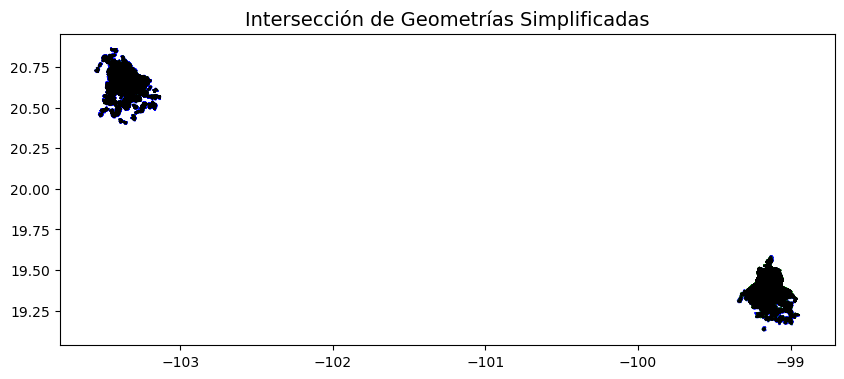

In [160]:
# Graficar el resultado de la intersección simplificada
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las geometrías originales en azul claro
inter.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)

# Graficar las geometrías simplificadas en verde
inter_join.plot(ax=ax, color='lightgreen', edgecolor='green', alpha=0.5)

# Graficar la intersección simplificada en rojo
simplified_intersection.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

# Títulos y visualización
plt.title('Intersección de Geometrías Simplificadas', fontsize=14)
plt.show()


In [162]:
simplified_intersection.drop(columns=["city_1"], inplace=True)
simplified_intersection.rename(columns={"city_2": "city"}, inplace=True)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,hex_id_9,city,type,pobtot,EspPublico,geometry
0,8b4995ba6588fff,11,0103000020E610000001000000070000000BD0A62EF0C8...,CDMX,11,0103000020E610000001000000070000000BD0A62EF0C8...,CDMX,11,0.185881,0.047103,...,-0.010758,-0.012197,0.025838,3.486848,894995ba65bffff,CDMX,urban,2039.0,1,"POLYGON ((-99.14036 19.38605, -99.14007 19.386..."
1,8b4995bb2addfff,11,0103000020E6100000010000000700000068C9A766D4C5...,CDMX,11,0103000020E6100000010000000700000068C9A766D4C5...,CDMX,11,0.118892,0.027617,...,-0.017982,-0.020709,0.029685,1.644124,894995bb2afffff,CDMX,urban,2148.0,1,"POLYGON ((-99.09179 19.41838, -99.09149 19.418..."
2,8b4995bb631dfff,11,0103000020E6100000010000000700000009012959D2C5...,CDMX,11,0103000020E6100000010000000700000009012959D2C5...,CDMX,11,0.287491,0.075361,...,-0.024106,-0.017269,0.089392,3.755980,894995bb633ffff,CDMX,urban,870.0,1,"POLYGON ((-99.09160 19.39622, -99.09131 19.396..."
3,8b499584059dfff,11,0103000020E610000001000000070000001A29DD85B4C9...,CDMX,11,0103000020E610000001000000070000001A29DD85B4C9...,CDMX,11,0.335775,0.098312,...,0.039553,0.033439,0.097250,2.788249,8949958405bffff,CDMX,urban,798.0,1,"POLYGON ((-99.15181 19.29191, -99.15152 19.291..."
4,8b4995845acdfff,11,0103000020E61000000100000007000000712BA49C9BCC...,CDMX,11,0103000020E61000000100000007000000712BA49C9BCC...,CDMX,11,0.533822,0.169322,...,0.110106,0.113493,0.131764,-3.565773,894995845afffff,CDMX,urban,1700.0,1,"POLYGON ((-99.19700 19.28620, -99.19747 19.286..."


In [163]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = simplified_intersection['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

simplified_intersection['EspPublico'] = intersects_public_spaces.astype(int)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,hex_id_9,city,type,pobtot,EspPublico,geometry
0,8b4995ba6588fff,11,0103000020E610000001000000070000000BD0A62EF0C8...,CDMX,11,0103000020E610000001000000070000000BD0A62EF0C8...,CDMX,11,0.185881,0.047103,...,-0.010758,-0.012197,0.025838,3.486848,894995ba65bffff,CDMX,urban,2039.0,1,"POLYGON ((-99.14036 19.38605, -99.14007 19.386..."
1,8b4995bb2addfff,11,0103000020E6100000010000000700000068C9A766D4C5...,CDMX,11,0103000020E6100000010000000700000068C9A766D4C5...,CDMX,11,0.118892,0.027617,...,-0.017982,-0.020709,0.029685,1.644124,894995bb2afffff,CDMX,urban,2148.0,1,"POLYGON ((-99.09179 19.41838, -99.09149 19.418..."
2,8b4995bb631dfff,11,0103000020E6100000010000000700000009012959D2C5...,CDMX,11,0103000020E6100000010000000700000009012959D2C5...,CDMX,11,0.287491,0.075361,...,-0.024106,-0.017269,0.089392,3.755980,894995bb633ffff,CDMX,urban,870.0,1,"POLYGON ((-99.09160 19.39622, -99.09131 19.396..."
3,8b499584059dfff,11,0103000020E610000001000000070000001A29DD85B4C9...,CDMX,11,0103000020E610000001000000070000001A29DD85B4C9...,CDMX,11,0.335775,0.098312,...,0.039553,0.033439,0.097250,2.788249,8949958405bffff,CDMX,urban,798.0,1,"POLYGON ((-99.15181 19.29191, -99.15152 19.291..."
4,8b4995845acdfff,11,0103000020E61000000100000007000000712BA49C9BCC...,CDMX,11,0103000020E61000000100000007000000712BA49C9BCC...,CDMX,11,0.533822,0.169322,...,0.110106,0.113493,0.131764,-3.565773,894995845afffff,CDMX,urban,1700.0,1,"POLYGON ((-99.19700 19.28620, -99.19747 19.286..."


In [164]:
cont_ceros_join = np.sum(simplified_intersection['EspPublico'] == 0)
cont_uno_join = np.sum(simplified_intersection['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 189438 
Número de Hexágonos con Espacios Públicos: 189438
Número total de Hexágonos: 378876


### Submuestreo de todas las variables

In [165]:
num_samples_join = len(simplified_intersection[simplified_intersection['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = simplified_intersection[simplified_intersection['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = simplified_intersection[simplified_intersection['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
simplified_intersection = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
simplified_intersection.reset_index(drop = True, inplace = True)
simplified_intersection.head()

,hex_id,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,ndvi_mean,ndvi_std,...,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,hex_id_9,city,type,pobtot,EspPublico,geometry
0,8b4995846a0efff,11,0103000020E6100000010000000700000089FC4AFED7C9...,CDMX,11,0103000020E6100000010000000700000089FC4AFED7C9...,CDMX,11,0.239553,0.051810,...,0.022954,0.018510,0.039170,0.550836,894995846a3ffff,CDMX,urban,682.0,1,"POLYGON ((-99.15404 19.27828, -99.15375 19.278..."
1,8b49958424dafff,11,0103000020E6100000010000000700000006CADD7253C8...,CDMX,11,0103000020E6100000010000000700000006CADD7253C8...,CDMX,11,0.170875,0.046430,...,0.018645,0.010528,0.082983,0.832709,8949958424fffff,CDMX,urban,645.0,1,"POLYGON ((-99.13050 19.30693, -99.13032 19.307..."
2,8b4995851c6bfff,11,0103000020E61000000100000007000000AA29E25382C7...,CDMX,11,0103000020E61000000100000007000000AA29E25382C7...,CDMX,11,0.135511,0.027419,...,-0.045433,-0.045057,0.029893,0.601372,894995851c7ffff,CDMX,urban,2088.0,1,"POLYGON ((-99.11715 19.30626, -99.11686 19.306..."
3,8b49958e48cafff,11,0103000020E610000001000000070000002B842F1F81C2...,CDMX,11,0103000020E610000001000000070000002B842F1F81C2...,CDMX,11,-0.012805,0.056860,...,0.085249,0.092395,0.101323,-3.151638,8949958e48fffff,CDMX,urban,305.0,1,"POLYGON ((-99.03976 19.27522, -99.03947 19.275..."
4,8b499585a059fff,11,0103000020E61000000100000007000000678A964C55C7...,CDMX,11,0103000020E61000000100000007000000678A964C55C7...,CDMX,11,0.131000,0.028524,...,0.000233,-0.000910,0.032760,2.249536,89499585a07ffff,CDMX,urban,2303.0,1,"POLYGON ((-99.11492 19.36147, -99.11475 19.361..."


In [166]:
contador_ceros_join = np.sum(simplified_intersection['EspPublico'] == 0)
contador_uno_join = np.sum(simplified_intersection['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 189438 
Número de Hexágonos con Espacios Públicos: 189438
Número total de Hexágonos: 378876


### Clasificadores para temperatura, humedad, población, vegetación...

In [167]:
xxx = simplified_intersection[["pobtot", 'ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', 'temp_diff_mean']]
yyy = simplified_intersection['EspPublico']

In [168]:
yyy.unique()

array([1, 0])

### Logistic Regression

In [169]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.2, random_state=42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  # Asegúrate de que 'target' sea el nombre de tu columna objetivo

# Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

# Ahora separa de nuevo x_train y y_train
x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

# Hacer lo mismo para el conjunto de prueba
test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

# Asegurarte de que el conjunto de prueba no tenga NaN
x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

# Escalar los datos
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

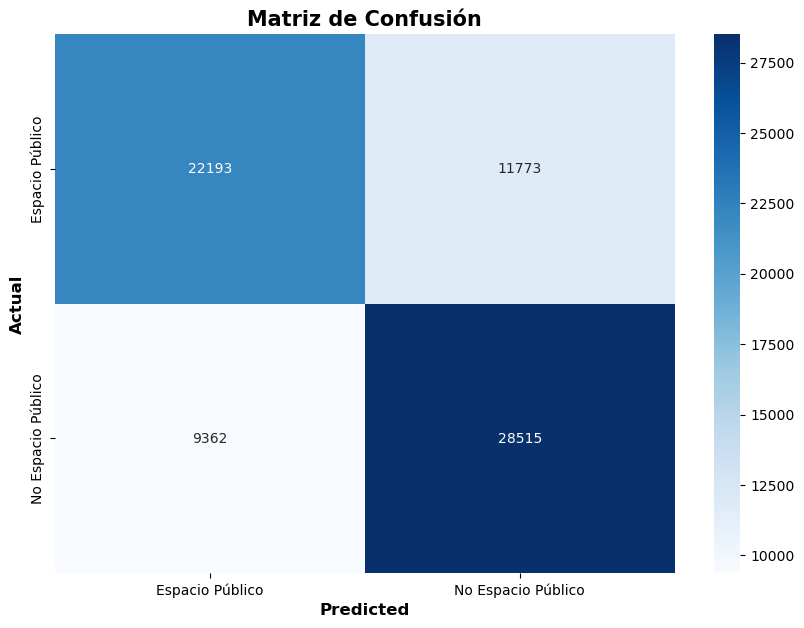

In [170]:
clf2 = LogisticRegression()
clf2.fit(x_train_scale, y_train_clean)

y_pred = clf2.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [171]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7058168506326294


In [172]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.68     33966
           1       0.71      0.75      0.73     37877

    accuracy                           0.71     71843
   macro avg       0.71      0.70      0.70     71843
weighted avg       0.71      0.71      0.70     71843



### Naive Bayes

In [173]:
nb3 = GaussianNB()
nb3.fit(x_train_scale, y_train_clean)

GaussianNB()

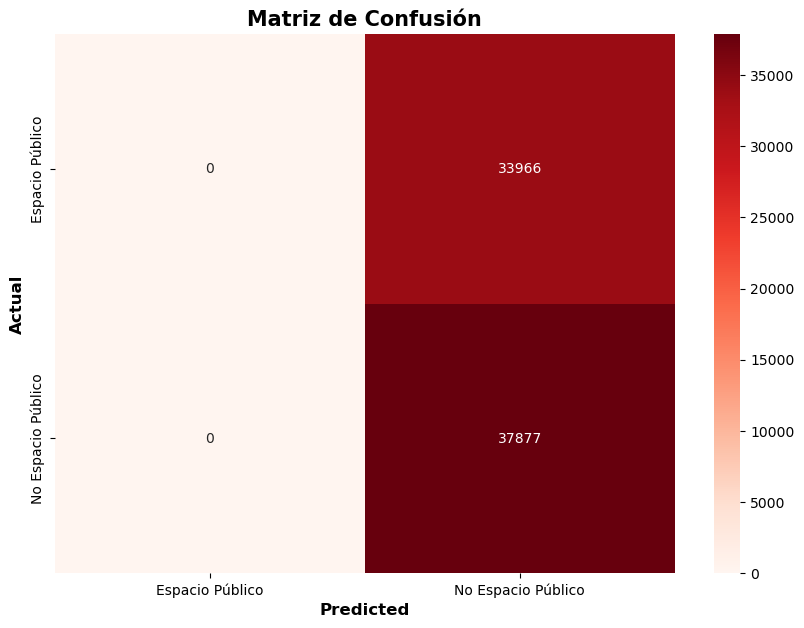

In [174]:
y_prend = nb3.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [175]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5272190749272719


In [176]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     33966
           1       0.53      1.00      0.69     37877

    accuracy                           0.53     71843
   macro avg       0.26      0.50      0.35     71843
weighted avg       0.28      0.53      0.36     71843



### Random Forest Classifier

In [177]:
rf3 = RandomForestClassifier(n_estimators=120, random_state=42)  
rf3.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf3.predict(x_test_clean)

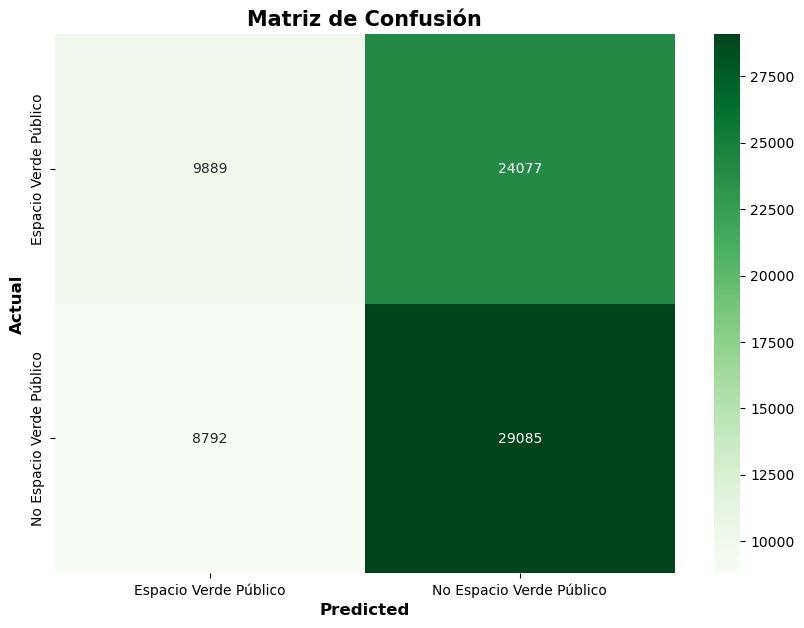

In [178]:
cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [179]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5424884818284315


In [180]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.53      0.29      0.38     33966
           1       0.55      0.77      0.64     37877

    accuracy                           0.54     71843
   macro avg       0.54      0.53      0.51     71843
weighted avg       0.54      0.54      0.51     71843



### Ada Boost Clasifier

In [181]:
model2 = AdaBoostClassifier(n_estimators = 100)
model2.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=100)

In [182]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([1, 1, 0, ..., 1, 0, 1])

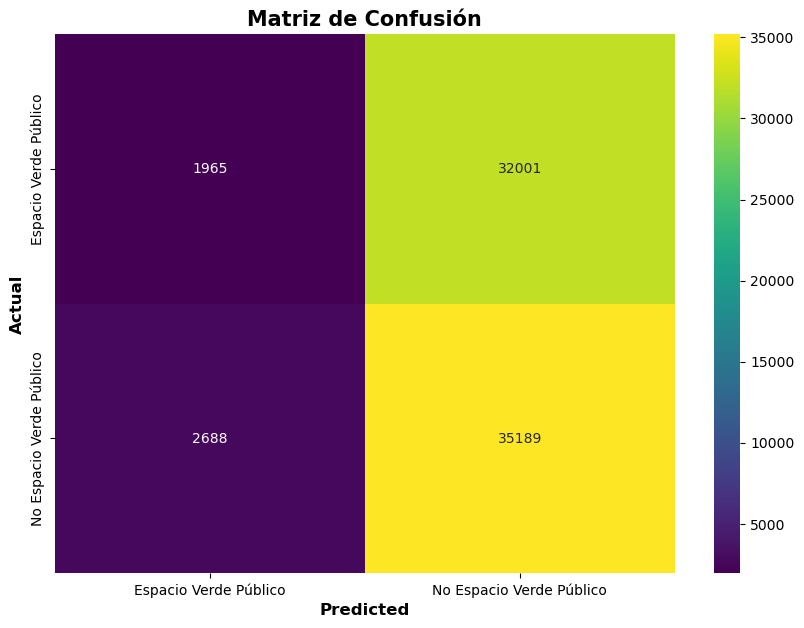

In [183]:
cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [184]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.42      0.06      0.10     33966
           1       0.52      0.93      0.67     37877

    accuracy                           0.52     71843
   macro avg       0.47      0.49      0.39     71843
weighted avg       0.48      0.52      0.40     71843



### XGB Classifier

In [185]:
model22 = xgb.XGBClassifier()
model22.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [186]:
predictions22 = model22.predict(x_test_clean)
predictions22

array([1, 0, 0, ..., 1, 0, 1])

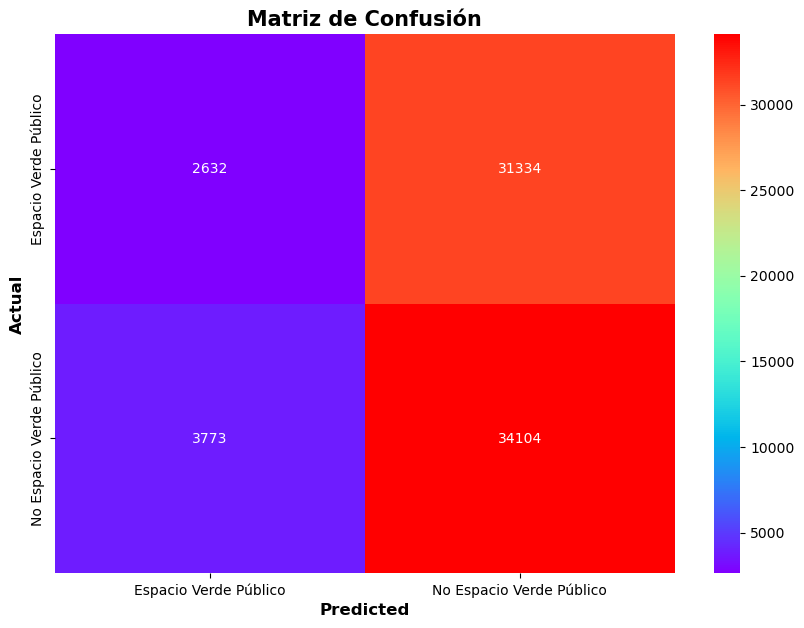

In [187]:
cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [188]:
print(classification_report(y_test_clean, predictions22))

              precision    recall  f1-score   support

           0       0.41      0.08      0.13     33966
           1       0.52      0.90      0.66     37877

    accuracy                           0.51     71843
   macro avg       0.47      0.49      0.40     71843
weighted avg       0.47      0.51      0.41     71843



In [189]:
accuracy = accuracy_score(y_test_clean, predictions22)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5113372214411982


### Decision Tree Classfier

In [190]:
model32 = DecisionTreeClassifier()
model32.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [191]:
predictions32 = model32.predict(x_test_clean)
predictions32

array([1, 1, 1, ..., 1, 1, 1])

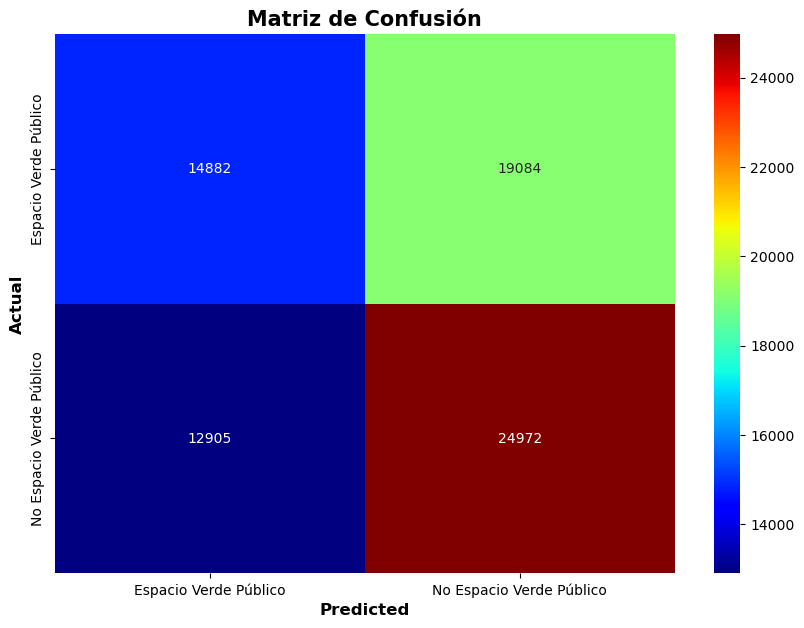

In [192]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [193]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.54      0.44      0.48     33966
           1       0.57      0.66      0.61     37877

    accuracy                           0.55     71843
   macro avg       0.55      0.55      0.55     71843
weighted avg       0.55      0.55      0.55     71843



In [194]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.554737413526718
